In [1]:
# plot_mc from kite
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import sys
sys.path.append('../../')
import bemppUQ

text = glob.glob('./results/*.txt')
S = [re.sub("[^0-9]", "",text) for text in text]
S = np.array(S, dtype=int)

axis= 2
#for run in {1..20}; do python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py; done


#for run in {1..2}; do python3 main.py&python3 main.py&python3 main.py&python3 main.py&python3 main.py; done
nrank = 6
M = len(text)
M = 500
print(M)
def get_mc(M):
    solt = []
    for m in range(M):
        Ut =np.loadtxt(text[m])
        Ut = Ut[[0,2,4],:] + 1j * Ut[[1,3,5],:]
        solt.append(Ut[axis])

    Umean = np.sum(np.array(solt), axis = 0) / M

    vart = []
    for i in range(M):
        vart.append( (solt[i] - Umean) * np.conj(solt[i] - Umean) )


    Uvar = np.sum(np.array(vart), axis=0) / M
    return Umean, Uvar

Umean_MC, Uvar_MC = get_mc(M)
Umean1_MC, Uvar1_MC = get_mc(40)

config = bemppUQ.config.set_case('A')
angles = config['angles']
n = config['number_of_angles']


500


In [2]:
precision = 10
name = 'results/full/' + str(nrank) + '_' + str(precision) + '.txt'
output = np.load(name + ".npy", allow_pickle=True).item()

In [3]:
result = output['result']
Umean = output['Umean']
result = output['result']

nrank = 6

def tensor_rank(result0, result1):
    Sigma = np.zeros((n, n), dtype=np.complex128)
    k = 0
    for ii in range(nrank):
        for jj in range(nrank):
            ff0 = result[k][axis]
            ff1 = result[k][axis]
            Sigma += 1/3. * bemppUQ.utils.login.tensorize(ff0,ff1)
            k += 1
    return Sigma

t = 0.05
Sigma = tensor_rank(result, result)
Uvars = t ** 2 * Sigma.diagonal()
Umeans = Umean[axis]

In [4]:
# CT

L0 = 0
L = 2

precision_list = [2, 5, 10]

uh_list = []
for precision in precision_list:
    name = 'results/full/' + str(nrank) + '_' + str(precision) + '.txt'
    output = np.load(name + ".npy", allow_pickle=True).item()

    result = output['result']

    uh_list.append(result) #result[0][axis])

Sigma_hat = np.zeros([n, n], dtype=np.complex128)

N_hat = 0
N_max = 0

N_list = [270, 792, 3204]

for l in range(0, L+1-L0):  
    
    i0 = L0 + l
    i1 = L - l
    if i0 <= i1:
        N0 = N_list[i0]
        N1 = N_list[i1]
        u0 = uh_list[i0]
        u1 = uh_list[i1]

        Temp = tensor_rank(u0, u1)
        #np.dot(np.array([u0]).T, np.array([u1]).conj())
        Sigma_hat += Temp
        if i0 != i1:
            Sigma_hat += Temp.conj().T
        N_hat += N0 * N1
        N_max = np.max([N_max, N0 * N1])


for l in range(0, L-L0):
    i0 = L0 + l
    i1 = L - l - 1 
    if i0 <= i1:
        N0 = N_list[i0]
        N1 = N_list[i1]

        u0 = uh_list[i0]
        u1 = uh_list[i1]
        
        Temp = tensor_rank(u0, u1)
        #Temp = np.dot(np.array([u0]).T, np.array([u1]).conj())
        Sigma_hat -= Temp
        if i0 != i1:
            Sigma_hat -= Temp.conj().T

        N_hat += N0 * N1
        N_max = np.max([N_max, N0 * N1])

print('N^2', N_list[2] ** 2, 'N_hat',  N_hat, 'n_max', N_max)
print('comp_hat', N_hat / (N_list[2] ** 2), 'comp_max', N_max / (N_list[2] ** 2))
Uvars_hat = t**2 * Sigma_hat.diagonal()

N^2 10265616 N_hat 1706184 n_max 865080
comp_hat 0.16620376215124352 comp_max 0.08426966292134831


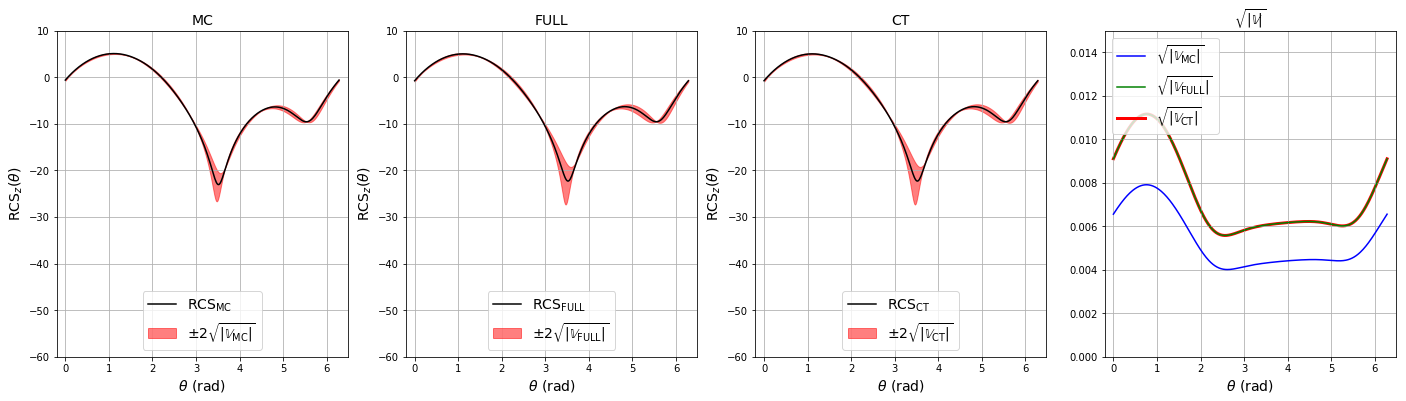

0.019979353529535712 relative norm error RCS
0.3931248077239383 relative norm error var FULL
0.3931248077239383 relative norm error var CT


In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from bemppUQ.utils.login import tensorize

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24,6))


FFp = Umean_MC  + 2 * np.sqrt(np.abs(Uvar_MC))
FFm = Umean_MC  - 2 * np.sqrt(np.abs(Uvar_MC))

cs = 10 * np.log10(4 * np.pi * np.abs(Umean_MC)**2)
cs_FOAp = 10 * np.log10(4 * np.pi * np.abs(FFp)**2)
cs_FOAm = 10 * np.log10(4 * np.pi * np.abs(FFm)**2)

ax1.plot(angles, cs, color = 'k', label = r'$\mathrm{RCS}_\mathrm{MC}$')
ax1.fill_between(x= angles, y1= cs_FOAm, y2= cs_FOAp, alpha=0.5, color = 'red', label = r'$\pm 2 \sqrt{|\mathbb{V}_\mathrm{MC}|}$')

#cs1 = 10 * np.log10(4 * np.pi * np.abs(Umean1)**2)
cs1 = 10 * np.log10(4 * np.pi * np.abs(Umeans)**2)
FFp = Umeans  + 2 * np.sqrt(np.abs(Uvars))
FFm = Umeans  - 2 * np.sqrt(np.abs(Uvars))

cs_FOAp = 10 * np.log10(4 * np.pi * np.abs(FFp)**2)
cs_FOAm = 10 * np.log10(4 * np.pi * np.abs(FFm)**2)

ax2.plot(angles, cs1, color = 'k', label = r'$\mathrm{RCS}_\mathrm{FULL}$')
ax2.fill_between(x= angles, y1= cs_FOAm, y2= cs_FOAp, alpha=0.5, color = 'red', label = r'$ \pm2 \sqrt{|\mathbb{V}_\mathrm{FULL}|}$')


## ax3
cs1 = 10 * np.log10(4 * np.pi * np.abs(Umeans)**2)
FFp = Umeans  + 2 * np.sqrt(np.abs(Uvars_hat))
FFm = Umeans  - 2 * np.sqrt(np.abs(Uvars_hat))

cs_FOAp = 10 * np.log10(4 * np.pi * np.abs(FFp)**2)
cs_FOAm = 10 * np.log10(4 * np.pi * np.abs(FFm)**2)

ax3.plot(angles, cs1, color = 'k', label = r'$\mathrm{RCS}_\mathrm{CT}$')
ax3.fill_between(x= angles, y1= cs_FOAm, y2= cs_FOAp, alpha=0.5, color = 'red', label = r'$ \pm2 \sqrt{|\mathbb{V}_\mathrm{CT}|}$')


y = np.sqrt(np.abs(Uvar_MC))
y1 = np.sqrt(np.abs(Uvars))
y2 = np.sqrt(np.abs(Uvars_hat))

#y = 10 * np.log10(4 * np.pi * y **2)
#y1 = 10 * np.log10(4 * np.pi * y1 ** 2)

ax4.plot(angles, y, label = r'$\sqrt{|\mathbb{V}_\mathrm{MC}|}$', color = 'b')
ax4.plot(angles, y1, label = r'$\sqrt{|\mathbb{V}_\mathrm{FULL}|}$', color = 'g')
ax4.plot(angles, y2, label = r'$\sqrt{|\mathbb{V}_\mathrm{CT}|}$', color = 'r', linewidth=3, zorder=1)

ax1.set_title(r'MC', fontsize=14)
ax2.set_title(r'FULL', fontsize=14)
ax3.set_title(r'CT', fontsize=14)
ax4.set_title(r'$\sqrt{|\mathbb{V}|}$', fontsize=14)

ax1.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax1.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)

ax2.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax2.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)

ax3.set_xlabel(r'$\theta$ (rad)', fontsize=14)
ax3.set_ylabel(r'$\mathrm{RCS}_z(\theta)$', fontsize=14)

ax4.set_xlabel(r'$\theta$ (rad)', fontsize=14)


ymin = np.min([y.min(), y1.min()])
ymax = np.min([y.max(), y1.max()])

ax1.legend(loc = 'lower center', fontsize=14)
ax2.legend(loc = 'lower center', fontsize=14)
ax3.legend(loc = 'lower center', fontsize=14)
ax4.legend(loc = 'upper left', fontsize=14)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_xlim(-.2, 2 * np.pi + .2)
ax2.set_xlim(-.2, 2 * np.pi + .2)
ax3.set_xlim(-.2, 2 * np.pi + .2)
ax4.set_xlim(-.2, 2 * np.pi + .2)

ax1.set_ylim(-60,10)
ax2.set_ylim(-60,10)
ax3.set_ylim(-60,10)
ax4.set_ylim(0, 0.015)

#plt.savefig('plots/kite.pdf')
#plt.savefig('plots/kite.png')

plt.savefig('plots/fichera' + str(axis) + '.pdf', bbox_inches='tight')
plt.show(block=False)

print(np.linalg.norm(cs-cs1) / np.linalg.norm(cs), 'relative norm error RCS')
print(np.linalg.norm(y-y1) / np.linalg.norm(y), 'relative norm error var FULL')
print(np.linalg.norm(y-y2) / np.linalg.norm(y), 'relative norm error var CT')

